In [95]:
import numpy as np
import umap
import matplotlib.pyplot as plt
import gzip

In [96]:
f = gzip.GzipFile("../proc/chr19_embed_dims.npy.gz", "r")
embed_dim = np.load(f)
embed_dim.shape

(16809, 512, 64)

In [97]:
seq1_cls = embed_dim[-2:-1, 0:1, :].flatten()

In [98]:
all_stack = np.zeros((64,64))
for x in range(embed_dim.shape[0]):
    curr_stack = embed_dim[x:x+1, 0:1, :].flatten()
    all_stack = np.vstack((all_stack, curr_stack))

# removing the 0 rows
all_stack = all_stack[~np.all(all_stack == 0, axis=1)]
all_stack.shape

(16809, 64)

In [99]:
umap_red = umap.UMAP()

In [100]:
umap_embed = umap_red.fit_transform(all_stack)
umap_embed.shape

(16809, 2)

In [101]:
umap_embed[0:10, :]

array([[ 6.6487    ,  0.346418  ],
       [ 6.711223  ,  0.6843423 ],
       [ 5.5992274 , 10.678736  ],
       [14.136852  , -8.613496  ],
       [13.851825  , -8.32124   ],
       [ 6.160323  ,  2.0128794 ],
       [ 5.945129  ,  0.10699643],
       [ 4.328677  ,  1.8515351 ],
       [11.131449  , 15.58706   ],
       [ 6.382937  ,  2.0731275 ]], dtype=float32)

# chr 19 and 21 together
## Each dot is the cls token of one seq of 512 tokens.

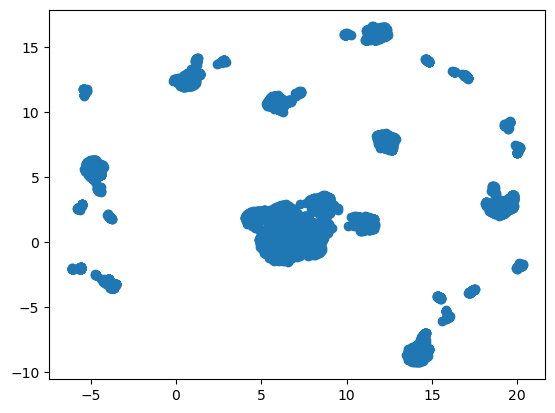

In [102]:
plt.scatter(umap_embed[:, 0], umap_embed[:, 1])

# chr 19 only

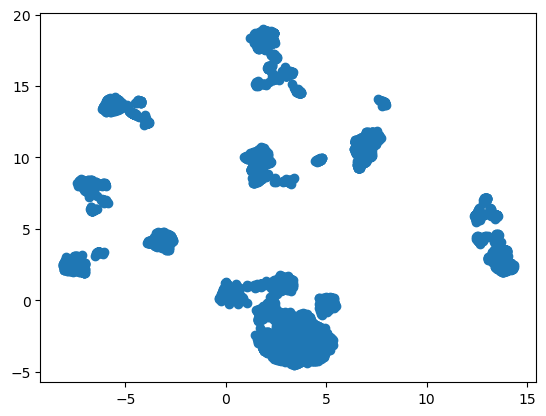

In [91]:
plt.scatter(umap_embed[:, 0], umap_embed[:, 1])